In [1]:
import os
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt

import segmentation_models_pytorch as smp
from segmentation_models_pytorch.encoders import get_preprocessing_fn

from utils.loss import DiceLoss, DiceBCELoss
from utils.dataset import BrainMRISliceDataset
from utils.utils import train, validate
from utils.metric import MetricsMonitor
from utils.vis import plot_mri

## Constants

In [16]:
ROOT_DIR = './Data/'
BATCH_SIZE = 16
EPOCHS = 300
DEVICE = 'mps' if torch.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_WORKERS = os.cpu_count()
LR = 1e-3

## Transforms

In [17]:
train_transform = A.Compose([
    # A.Resize(256, 256),  # Resize both image and mask
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize the image
    ToTensorV2()  # Convert to PyTorch tensors
], additional_targets={'mask': 'mask'})  # Specify the target name for the label

test_transform = A.Compose([
    # A.Resize(256, 256),
    A.LongestMaxSize(max_size=256),  # Resize the smallest side to 256, keeping the aspect ratio
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=0, value=0),  # Pad to a square image
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], additional_targets={'mask': 'mask'})

In [18]:
train_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'train'), slice_axis=2, transform=train_transform, num_classes=3, cache=True)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

val_dataset = BrainMRISliceDataset(os.path.join(ROOT_DIR, 'val'), slice_axis=2, transform=test_transform, num_classes=3, cache=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

In [19]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

torch.Size([16, 1, 256, 256]) torch.Size([16, 3, 256, 256])


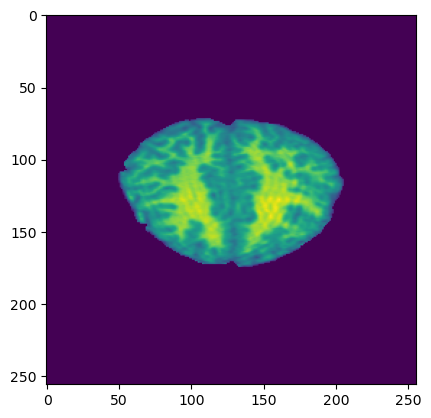

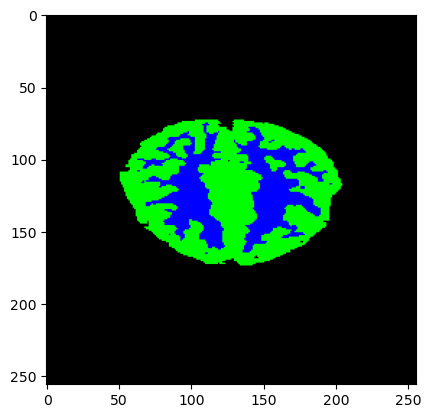

In [20]:
image, mask = train_dataset[180]
plt.imshow(image.permute(2, 1, 0).numpy())
plt.show()

plt.imshow(mask.permute(2, 1, 0).numpy())
plt.show()


## Models

In [21]:
model = smp.Unet(
    encoder_name="resnet50",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=3,                      # model output channels (number of classes in your dataset)
)

model = model.to(DEVICE)

## Loss & Optimizer

In [23]:
criteria = torch.nn.BCEWithLogitsLoss()
# criteria = DiceBCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

## Training

In [24]:
# Monitors
train_monitor = MetricsMonitor(metrics=["loss", "accuracy", "dice_score"])
val_monitor = MetricsMonitor(
    metrics=["loss", "accuracy", "dice_score"], patience=5, mode="max"
)
test_monitor = MetricsMonitor(metrics=["loss", "accuracy", "dice_score"])

In [ ]:
for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)
    train(model, train_loader, criteria, optimizer, DEVICE, train_monitor)
    validate(model, val_loader, criteria, DEVICE, val_monitor)

Epoch 1/300
----------
[Train] Iteration 160/160 - loss: 0.7208, accuracy: 0.6774, dice_score: 0.1531
Train Metrics - loss: 0.7208, accuracy: 0.6774, dice_score: 0.1531
[Validation] Iteration 80/80 - loss: 0.6909, accuracy: 0.6801, dice_score: 0.2220
Validation Metrics - loss: 0.6909, accuracy: 0.6801, dice_score: 0.2220
Epoch 2/300
----------
[Train] Iteration 160/160 - loss: 0.6893, accuracy: 0.6833, dice_score: 0.2635
Train Metrics - loss: 0.6893, accuracy: 0.6833, dice_score: 0.2635
[Validation] Iteration 80/80 - loss: 0.6902, accuracy: 0.6782, dice_score: 0.2223
Validation Metrics - loss: 0.6902, accuracy: 0.6782, dice_score: 0.2223
Epoch 3/300
----------
[Train] Iteration 160/160 - loss: 0.6880, accuracy: 0.6838, dice_score: 0.2842
Train Metrics - loss: 0.6880, accuracy: 0.6838, dice_score: 0.2842
[Validation] Iteration 80/80 - loss: 0.6880, accuracy: 0.6824, dice_score: 0.2720
Validation Metrics - loss: 0.6880, accuracy: 0.6824, dice_score: 0.2720
Epoch 4/300
----------
[Train] 

In [ ]:
model.eval()
model(train_dataset[0][0].unsqueeze(0).to(DEVICE)).shape

torch.Size([1, 3, 256, 256])